# Regressie
## Vragen over algoritme Random Forest
### Noem een voorbeeld uit de praktijk waarin jullie algoritme wordt gebruikt.
* Het algoritme Random Forest wordt gebruikt voor classificatie en regressieproblemen. Hieruit kan een efficiente oplossing worden verkregen. In de regressie wordt dit gebruikt met continue variabelen. Je zou het bijvoorbeeld kunnen gebruiken in het voorstellen van de koers op de beurs. Verder bij hele grote datasets die bijvoorbeeld in het ziekenhuis worden gebruikt, zo kan er efficiënt gesorteerd en verwerkt worden.

### Hoe werkt het algoritme conceptueel? Wat zijn de belangrijkste stappen?
* Stap 1: selecteer random datapunten van de trainingsset.
* Stap 2: Individuele descisiontrees worden gecontrueerd voor elk punt
* Stap 3: Elke descisiontree geeft een output. 
* Stap 4: Eind output wordt gebaseerd op *Majority Voting or Averaging* 

### Wat zijn de voor- en nadelen van jullie algoritme? In welke situaties werkt het heel goed en wanneer juist niet? 

#### Voordelen
* Het werkt goed voor het voorspellen of schatten van kansen op gebeurtenissen. 
* Daarnaast werkt het goed bij het imputeren van ontbrekende waarden in een dataset. 
* Ook werkt dit goed bij het detecteren van de belangrijkste invloedsfactoren voor gebeurtenissen in een dataset
* Het detecteerd verdachte gebeurtenissen of veranderingen in een dataset. 
* Het detecteerd patronen van verbanden of kenmerken in een dataset. 

#### Nadelen
* Random Forests zijn bevooroordeeld als het met categorische variabelen werkt. 
* Langzame training.
* Niet bruikbaar bij lineaire methoden.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor  # model (used in Building Tree walkthrough)
from sklearn.tree import plot_tree  # tree visualization
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Data verkenning

In [2]:
df = pd.read_csv('train.csv')

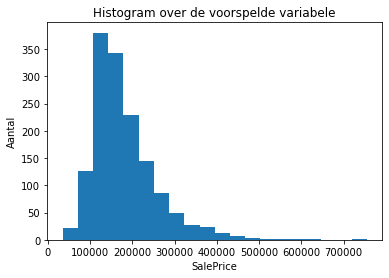

In [3]:
plt.hist(x='SalePrice', bins = 20, data = df) # Verdeling van de prijzen bekijken, deze later vergelijken met de predicions
plt.title('Histogram over de voorspelde variabele')
plt.xlabel('SalePrice')
plt.ylabel('Aantal')
plt.show()

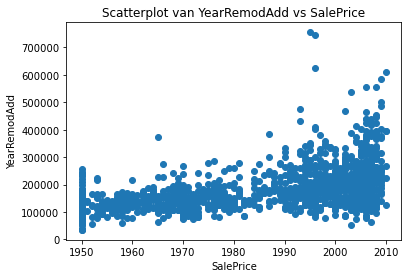

In [4]:
plt.scatter(df['YearRemodAdd'], df['SalePrice'])
plt.title('Scatterplot van YearRemodAdd vs SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('YearRemodAdd')
plt.show()

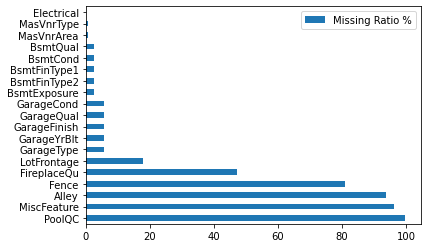

In [5]:
def plot_nas(df: pd.DataFrame): # NA-waardes weergeven per variabele
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)

In [6]:
df = df.select_dtypes(include=['float64', 'int64']) # Alleen numerieke variabelen gebruiken bij de regressie
df = df.dropna()

uniqueValues = df.nunique().sort_values(ascending=False).reset_index(inplace=False) # Aantal unieke waarnemingen per kolom, zodat de categorische variabelen makkelijk kunnen worden verwijderd
uniqueValues = pd.DataFrame(uniqueValues)
uniqueValues = uniqueValues.rename(columns={0: 'AantVar'})
uniqueValues = uniqueValues[uniqueValues['AantVar']>50] # Alleen de variabelen gebruiken die waarschijnlijk niet categorisch zijn (meer dan 50 unieke waardes per variabele gekozen)
print(uniqueValues) # Id heeft uiteraard allemaal verschillende waardes, dus vandaar de 1121

vari = uniqueValues['index'].tolist() # vari zijn alle variabalen in totaal, inclusief Id en SalePrice

vari_excl = vari.copy() # vari_excl zijn alle variabelen die als voorspellende variabelen kunnen worden gebruikt
vari_excl.remove('Id')
vari_excl.remove('SalePrice')

del vari[0]
df = df[vari]

df.head()

            index  AantVar
0              Id     1121
1         LotArea      817
2       GrLivArea      728
3       BsmtUnfSF      678
4        1stFlrSF      656
5     TotalBsmtSF      623
6       SalePrice      570
7      BsmtFinSF1      524
8      GarageArea      394
9        2ndFlrSF      351
10     MasVnrArea      282
11     WoodDeckSF      222
12    OpenPorchSF      176
13      YearBuilt      109
14     BsmtFinSF2      108
15    LotFrontage      107
16  EnclosedPorch       99
17    GarageYrBlt       97
18    ScreenPorch       63
19   YearRemodAdd       61


,LotArea,GrLivArea,BsmtUnfSF,1stFlrSF,TotalBsmtSF,SalePrice,BsmtFinSF1,GarageArea,2ndFlrSF,MasVnrArea,WoodDeckSF,OpenPorchSF,YearBuilt,BsmtFinSF2,LotFrontage,EnclosedPorch,GarageYrBlt,ScreenPorch,YearRemodAdd
0,8450,1710,150,856,856,208500,706,548,854,196.0,0,61,2003,0,65.0,0,2003.0,0,2003
1,9600,1262,284,1262,1262,181500,978,460,0,0.0,298,0,1976,0,80.0,0,1976.0,0,1976
2,11250,1786,434,920,920,223500,486,608,866,162.0,0,42,2001,0,68.0,0,2001.0,0,2002
3,9550,1717,540,961,756,140000,216,642,756,0.0,0,35,1915,0,60.0,272,1998.0,0,1970
4,14260,2198,490,1145,1145,250000,655,836,1053,350.0,192,84,2000,0,84.0,0,2000.0,0,2000


In [7]:
# Dubbel checken of kolommen wel waardes hebben naast 0 (zie df.head hierboven)
print(df['BsmtFinSF2'].unique())
print(df['ScreenPorch'].unique())

[   0  486  506  712  362   41  169  150   28  215  374  208  184  279
  180  580  690  692  228  125 1063  620  175  820 1474  479  232  380
  544  294  121  391  531  344  539  713  210  311  165  532   96  495
  174 1127  139  645  123  551  606  147  612  182  132  336  468  287
  119   40  117  239  472   64 1057  127  480  128  377  345 1085  823
  500  290  634  411  841 1061  466  396  149  273  465  682  106  240
  547  177  108  600  492  168  438  144  906  608  276  661  173  972
  105  420  469  546  352  872  110  627  163 1029]
[  0 198 291 252  99 168 130 192 410 224 266 170 153 144 142 128 259 160
 271 234 374  90 176 276 180 161 145 200 122 120  60 126 189 260 147 385
 287 156 100 216 210 204 152 175 312 265 322 190  63  53 143 288 263  80
 163 116 480 178 440 155 220 119 165]


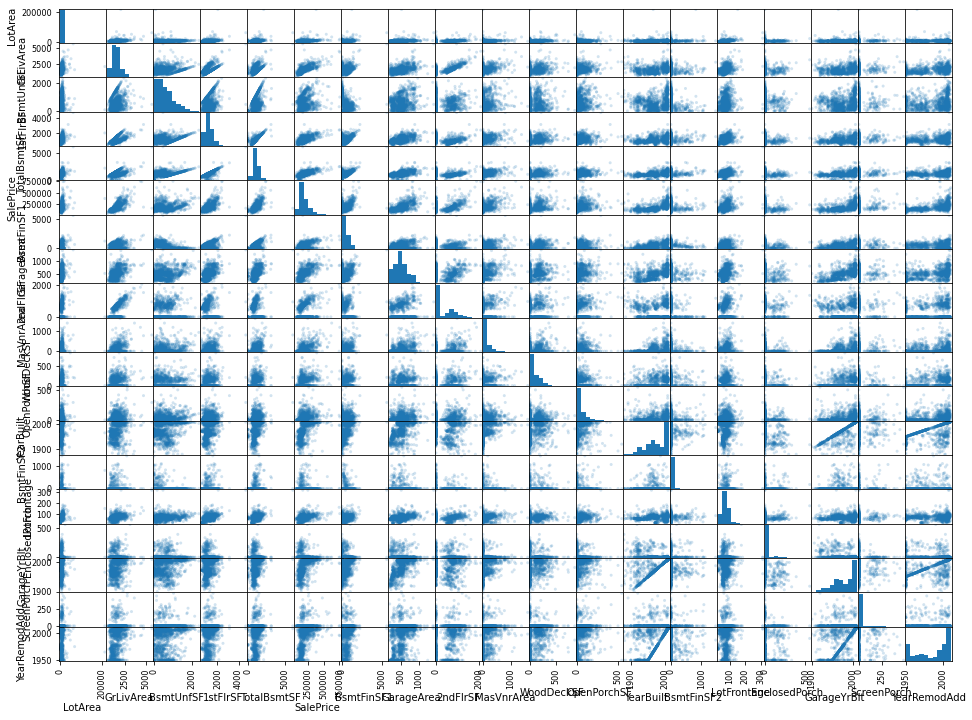

In [8]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(16, 12)) # Dubbel checken of er geen categorische variabelen meer over zijn
plt.show()
# Het bouwjaar van het huis en het bouwjaar van de garage zijn waarschijnlijk heel erg afhankelijk van elkaar, 
# dus een van deze zullen we waarschijnlijk uit het model kunnen halen zonder veel gevolgen op de uitkomst. Verder zijn er weinig onderling afhankelijk variablen te vinden.

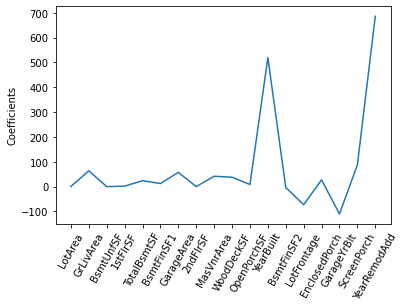

                        0
YearRemodAdd   685.612961
YearBuilt      519.250471
ScreenPorch     87.547556
GrLivArea       63.532276
GarageArea      57.495420
MasVnrArea      41.833457
WoodDeckSF      37.940593
EnclosedPorch   27.288319
TotalBsmtSF     23.946773
BsmtFinSF1      12.416028
OpenPorchSF      8.479094
1stFlrSF         1.971616
LotArea          0.698632
2ndFlrSF         0.000000
BsmtUnfSF        0.000000
BsmtFinSF2      -3.491034
LotFrontage    -72.639835
GarageYrBlt   -110.014483


In [9]:
# Bekijken welke variabelen het meest invloed hebben op de prijs m.b.v. de lasso methode
X = df.drop('SalePrice', axis = 1).values
y = df.SalePrice.values
names = df.drop('SalePrice', axis=1).columns
lasso = Lasso(alpha = 0.4, normalize = True)

lasso_coef = lasso.fit(X, y).coef_
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show() # De pieken hebben het meeste invloed en deze variabelen zullen we sowieso gebruiken in het model

data = pd.DataFrame(lasso_coef, names).sort_values(by=0, ascending=False)
print(data)

## Uitleg Prestatiemetrics
* We hebben deze metrics gekozen omdat we de uitschieters erg belangrijk vinden.
#### Voordelen van de prestatie metrics
* De r^2 is handig, want dan kan je zien hoe goed het model is. 
* RMSE is handig om de outliers te detecteren. 
* Als de rmse wordt gebruikt in een loss functie, is het makkelijker om de afgeleide te berekenen. 
#### Nadelen van de prestatie metrics
* De R-squared kan niet bepalen of de coefficienten schatters en voorspellingen biased zijn. 
* De R-squared wordt altijd hoger als er een voorspeller wordt toegevoegd. 
* RMSE moet worden vergeleken met anderen RMSE om te zien of deze goed of slecht is. 

## Enkelvoudige Lineaire Regressie

In [10]:
X = df.YearRemodAdd.values.reshape(-1, 1)
y = df.SalePrice.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     417.5
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           4.17e-79
Time:                        17:29:06   Log-Likelihood:                -14110.
No. Observations:                1121   AIC:                         2.822e+04
Df Residuals:                    1119   BIC:                         2.823e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -3.9e+06      2e+05    -19.503   

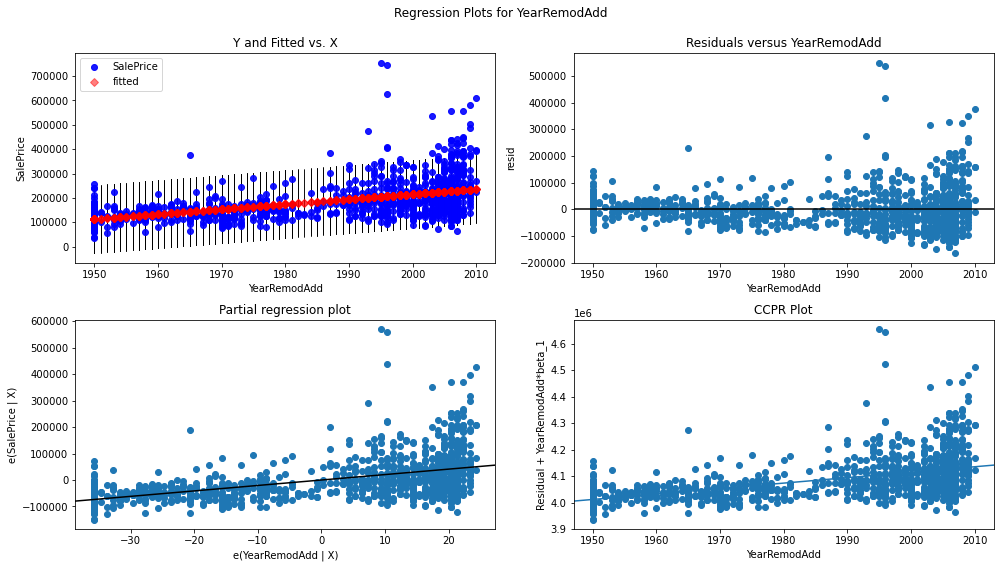

In [11]:
model = ols('SalePrice ~ YearRemodAdd', data=df).fit() # YearRemodAdd heeft het meeste invloed op de prijs volgens de lasso methode, dus hierop voeren we enkelvoudige regressie uit
print(model.summary())
# De vergelijking gaat als volgt: Y = 2057.6256X + -3.9e+06, dus ongeveer Y = 2057.6256X 

fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(model, 'YearRemodAdd', fig=fig)
plt.show() # De residuen zijn opzich mooi verdeeld rondom 0. Wel is de R-squared nog laag voor een variabele met veel invloed volgens de lasso methode

In [12]:
model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred_test = model1.predict(X_test)
y_pred_train = model1.predict(X_train)

print("R^2 test data: {}".format(model1.score(X_test, y_test)))
print("R^2 train data: {}".format(model1.score(X_train, y_train)))

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Root Mean Squared Error test data: {}".format(rmse_test))
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Root Mean Squared Error train data: {}".format(rmse_train))
# De 'R Squared' geeft aan hoeveel van de variantie in de afhankelijke variabele (gewicht) verklaard wordt door de verklarende variabelen. 
# Dit betekend dat de variantie in de afhankelijke variabele in de test data lager is dan de train data.
# De root mean squared error neemt de uitschieters minder heftig mee, door het nemen van de wortel van het kwadraat.

kf = KFold(n_splits=20, shuffle=True, random_state=5)
reg = LinearRegression()
cv_scores = cross_val_score(reg, X, y, cv=kf)
print(cv_scores)
# Hoe hoger de n_splits, hoe beter de voorspelling is, aangezien de training vaker wordt uitgevoerd,
# echter duurt het ook een stuk langer om dit te verwerken voor de pc.
# 10 kan de pc in dit geval makkelijk aan en geeft een relatief goede voorspelling naar aanleiding van de training.
# De data die uit een hoge n_splits voort komt zal het meeste lijken op de train data, aangezien het model hieruit heeft geleerd.
# Bij een lage n_splits zal de data wellicht meer op de test data lijken.

R^2 test data: 0.24773069090364908
R^2 train data: 0.28088647207934003
Root Mean Squared Error test data: 77535.38182149643
Root Mean Squared Error train data: 67740.80534599515
[0.26835101 0.20059055 0.22546452 0.32939106 0.23246097 0.39222822
 0.1612744  0.23187171 0.22904771 0.40424067 0.40495866 0.28989579
 0.3823701  0.22207558 0.18003842 0.22346904 0.28575966 0.30781862
 0.18487698 0.23694189]


#### Hyperparameters
* We kunnen de test omvang veranderen. Hierdoor wordt de test dataset groter en de train dataset kleiner. Als de test dataset groter wordt is er een kleinere dataset om het model mee te trainen. 
* Ook kunnen we de random state aanpassen in de functie. Dit gaat over het aantal regels van de data en hoe random deze wordt gemaakt. 

#### Underfit model

In [13]:
X = df.LotArea.values.reshape(-1, 1)
y = df.SalePrice.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

underfit = LinearRegression()
underfit.fit(X_train, y_train)
y_pred_test = underfit.predict(X_test)
y_pred_train = underfit.predict(X_train)
print("R^2 test data: {}".format(underfit.score(X_test, y_test)))
print("R^2 train data: {}".format(underfit.score(X_train, y_train)))
#Hierbij zie je dat de R^2 heel laag is. 

R^2 test data: 0.09092496200388644
R^2 train data: 0.07694497848840431


#### Overfit model

In [14]:
X = df.drop('SalePrice', axis = 1).values
y = df.SalePrice.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
overfit = LinearRegression()
overfit.fit(X_train, y_train)

print("R^2 test data: {}".format(overfit.score(X_test, y_test)))
print("R^2 train data: {}".format(overfit.score(X_train, y_train)))

R^2 test data: 0.757999670965512
R^2 train data: 0.7116732211024513


In [15]:
import warnings
warnings.filterwarnings("ignore")

param_grid = {"alpha": np.linspace(1e-05, 1, 20)}
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf) # kf gebruiken we om de data op splitsen in delen tijdens het trainen, waarom we dit doen staat
# uitgelegd bij de kf definitie boven het kopje hyperparameters.
lasso_cv.fit(X_train, y_train)
print("Tuned lasso paramaters: {}".format(lasso_cv.best_params_)) # beste alpha ia 1 tijdens het opstellen van lasso
print("Tuned lasso score: {}".format(lasso_cv.best_score_)) # de beste score die hieruit komt is 0.677, wat naar onze mening een goed model is

lasso = Lasso(alpha = 1.0, normalize = True) # hier lasso gedefinieerd met een alpha van 1.0 en hieronder de verschillen berekend
param_grid = {"alpha": np.linspace(1e-05, 1, 20)}
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf)
lasso_cv.fit(X_train, y_train)
print("Tuned lasso score: {}".format(lasso_cv.best_score_)) # de score verandert niks

Tuned lasso paramaters: {'alpha': 1.0}
Tuned lasso score: 0.6773613247866577
Tuned lasso score: 0.6773613247866577


## Enkelvoudige Random Forest Regressie

In [16]:
df4 = df.copy()

In [17]:
#Enkelvoudige regressie
y = np.array(df4.SalePrice) 
X = np.array(df4.YearRemodAdd).reshape(-1, 1) #reshapen van x waarden in 2D array
reg = RandomForestRegressor().fit(X, y) # regressie
print(reg.score(X,y)) # score van enkelvoudig model
df4['pred_y'] = reg.predict(X) #voorspelling maken voor in het plot

0.34434969365662405


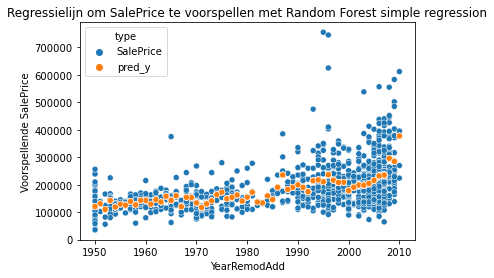

In [18]:
df2 = df4[['YearRemodAdd', 'SalePrice', 'pred_y']] # selecteren van alleen benodigde variabelen
df3 = df2.melt(id_vars = 'YearRemodAdd', var_name = 'type', value_name = 'y_pred') #omzetten naar voorspelling y waarden en echte y waarden

sns.scatterplot(x = 'YearRemodAdd', y = 'y_pred', hue = 'type', data = df3) # plotten
plt.title('Regressielijn om SalePrice te voorspellen met Random Forest simple regression')
plt.xlabel('YearRemodAdd')
plt.ylabel('Voorspellende SalePrice')
plt.show()

## Meervoudige Random Forest Regressie

In [19]:
# De data op een random volgorde neerzetten om de random forest ook echt random te laten uitvoeren
def bootstrap(df):
    n_rows = df.shape[0]
    random_rows = np.random.randint(n_rows, size=n_rows)
    return df.iloc[random_rows, :]
dfb = bootstrap(df)

In [20]:
rand_tree = DecisionTreeRegressor(
    max_features="sqrt"
)

rand_tree.fit(
    X=dfb.drop(columns=['SalePrice']),
    y=dfb['SalePrice']
)

DecisionTreeRegressor(max_features='sqrt')

In [21]:
random_forest_list = []
random_forest_list.append(rand_tree) 

for i in range(8):
    dfb = bootstrap(df)
    rand_tree = DecisionTreeRegressor(
        max_features="sqrt"
    )
    
    rand_tree.fit(
        X=dfb.drop(columns=["SalePrice"]),
        y=dfb["SalePrice"]
    )
    
    random_forest_list.append(rand_tree)

In [22]:
def get_grid_coord(k, n):
    return k // n, k % n

In [23]:
inputs = pd.DataFrame([{"LotArea": 10000, "GrLivArea": 8000, "BsmtUnfSF": 200, "1stFlrSF": 4000, "TotalBsmtSF": 4000,
                       "BsmtFinSF1": 800, "GarageArea": 500, "2ndFlrSF": 700, "MasVnrArea": 100, "WoodDeckSF": 0,
                       "OpenPorchSF": 30, "YearBuilt": 1999, "BsmtFinSF2": 100, "LotFrontage": 70, "EnclosedPorch": 100,
                       "GarageYrBlt": 1999, "ScreenPorch": 100, "YearRemodAdd": 1999}]) # Berekenen van de prijs bij bepaalde gegevens van een huis (random ingevuld met waarschijnlijke waardes)

prediction = 0
for i, rand_tree in enumerate(random_forest_list):
    prediction += rand_tree.predict(inputs)[0]

prediction /= 9 # Er zijn 9 bomen gebruikt, hierdoor moet de voorspelling dus worden gedeeld
prediction = round(prediction, 2)

print(f"Random Forest's predicted Sale Price: ${prediction}")

Random Forest's predicted Sale Price: $329017.44


## Definitieve model

R^2: 0.8350916027869222


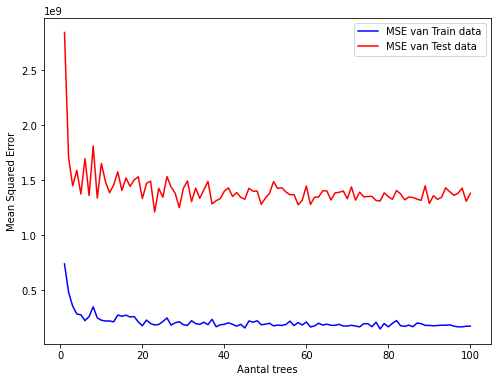

In [24]:
# De X en y definieren 
X = df[['LotArea', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', 'TotalBsmtSF', 'BsmtFinSF1', 'GarageArea', '2ndFlrSF', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'YearBuilt', 'BsmtFinSF2', 'LotFrontage', 'EnclosedPorch', 'GarageYrBlt', 'ScreenPorch', 'YearRemodAdd']].values
y = df.SalePrice.values

# Dataset splitsen in een train en een testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Kijken welk aantal 'trees' het best past bij ons model
rf = RandomForestRegressor(n_estimators=1)
trees, train_loss, test_loss = [], [], []
for iter in range(100):
    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_predicted)
    mse_test = mean_squared_error(y_test, y_test_predicted)
    trees += [rf.n_estimators]
    train_loss += [mse_train]
    test_loss += [mse_test]
    rf.n_estimators += 1

plt.figure(figsize=(8,6))  
plt.plot(trees, train_loss, color="blue", label="MSE van Train data")
plt.plot(trees, test_loss, color="red", label="MSE van Test data")
plt.xlabel("Aantal trees")
plt.ylabel("Mean Squared Error");
plt.legend() # Hoe meer trees, hoe minder de overfit. We gebruiken in het definitieve model hieronder dus 100 trees om dit te optimaliseren.

# Model maken met het juiste aantal trees. 
rf_r = RandomForestRegressor(n_estimators=100)
rf_r.fit(X_train, y_train)

# Voorspelling maken voor SalePrice
y_pred = rf_r.predict(X_test)
r_squared = rf_r.score(X_test, y_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the metrics
print("R^2: {}".format(r_squared)) # Underfit is ook niet aan de orde in ons definitieve model, sinds de R-squared een hoge waarde van 0,83 heeft.

# Classificatie
## Vragen over algoritme Nearest Neighbor

### Noem een voorbeeld uit de praktijk waarin jullie algoritme wordt gebruikt.
* Bij classificatie aan de hand van discrete variabelen en bij regressie aan de hand van continue variabelen. 

### Hoe werkt het algoritme conceptueel? Wat zijn de belangrijkste stappen?
* Stap 1: Selecteer het nummer K aan neighbors.
* Stap 2: Bereken de *Euclidean distance* van aantal gekozen neighbors.
* Stap 3: Neem de K nearest neighbors per berekende *Euclidean distance*
* Stap 4: Naast deze K neighbors, tel het aantal datapunten in elke categorie.
* Stap 5: Wijs de nieuwe datapunten toe aan de categorie voor welk nummer neighbors het maximum is.
* Stap 6: Model is klaar. 

### Wat zijn de voor- en nadelen van jullie algoritme? In welke situaties werkt het heel goed en wanneer juist niet?
#### Voordelen:
* Makkelijk algoritme wat makkelijk te begrijpen is. 
* Gebruikt bij niet-lineaire data. 
* Kan worden gebruikt voor classificatie en regressie. 
* Geeft hoge nauwkeurigheid, maar er zijn meer goede algoritmes in supervised modellen.

#### Nadelen:
* Vereist grote opslag.
* Voorspellingsrate is langzaam.
* Slaat alle trainingsdata op.
* Het algoritme wordt langzamer als het aantal voorbeelden, voorspellers of onafhankelijke variabelen groter wordt.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix 
from IPython.display import Image

In [26]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [28]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [29]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

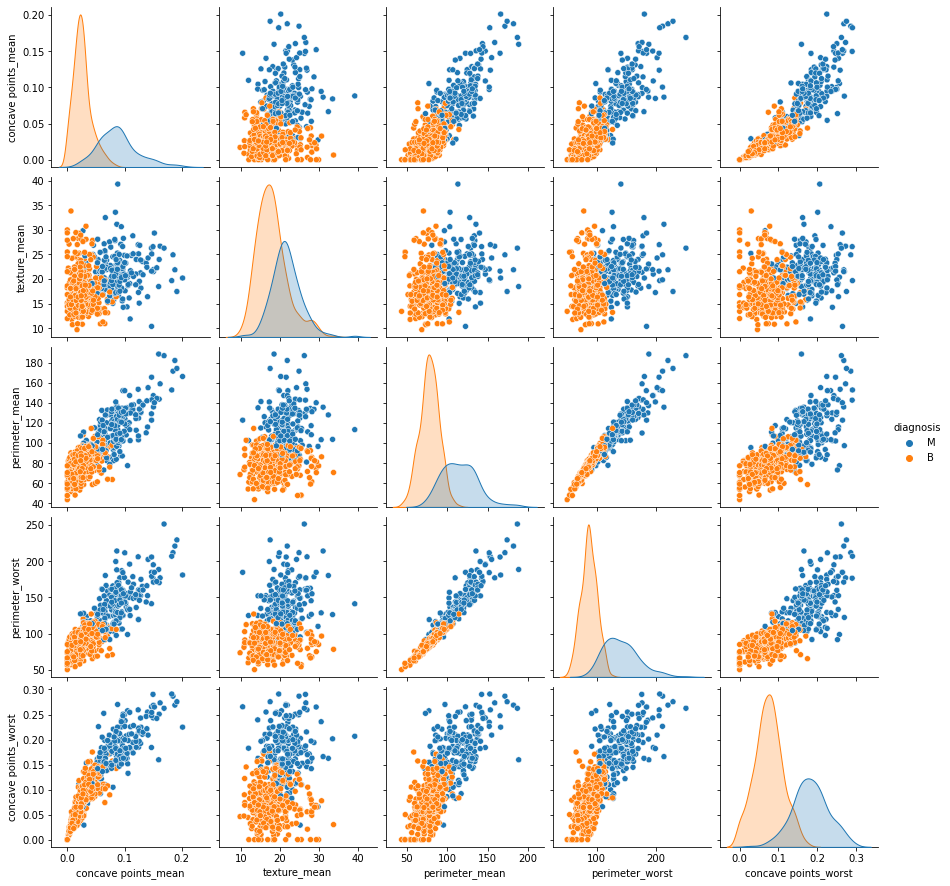

In [30]:
#kijken of er verbanden zitten tussen M/B en de andere variabelen
sns.pairplot(df, hue="diagnosis", vars=["concave points_mean", "texture_mean", "perimeter_mean", "perimeter_worst", "concave points_worst"])
plt.show()

#je ziet een duidelijke groepering van de M- en B- bolletjes in de figuren, bij de kwaadaardige cellen zit het resultaat altijd hoger dan de goedaardige

In [31]:
#de stringvariabelen M en B in diagnosis veranderen naar code respectievelijk 1 en 0
encoder = LabelEncoder()
df['diagnosis']=encoder.fit_transform(df['diagnosis'])
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [32]:
#onnodige kolommen weghalen en een correlatie matrix van maken
df2 = df.drop(['id','Unnamed: 32'], axis = 1)
corr_matrix = df2.corr()
corr_matrix

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,...,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.358560,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


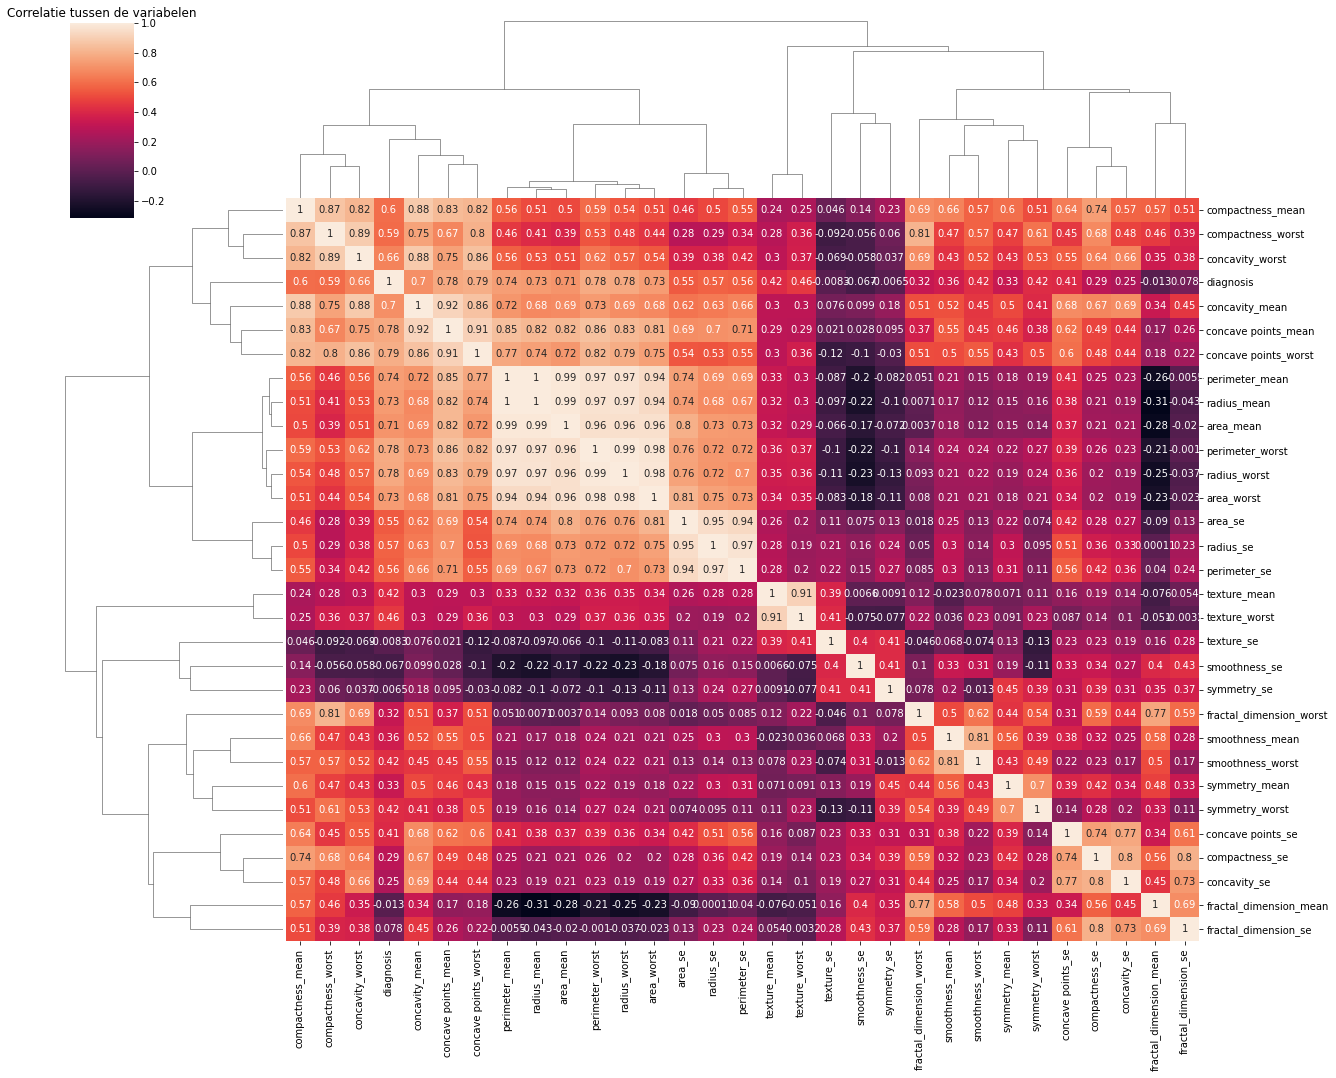

In [33]:
#correlatie matrix weergeven in een plot met kleuren op basis van hoe sterk de correlatie is
sns.clustermap(corr_matrix, annot = True, figsize = (18, 15))
plt.title("Correlatie tussen de variabelen")
plt.show()

In [34]:
#verder kijken naar de sterk gecorreleerde variabelen met het bepalen van een grens
grens = 0.77
filter_ = np.abs(corr_matrix['diagnosis']) > grens
corr_features = corr_matrix.columns[filter_].tolist()
corr_features

['diagnosis',
 'concave points_mean',
 'radius_worst',
 'perimeter_worst',
 'concave points_worst']

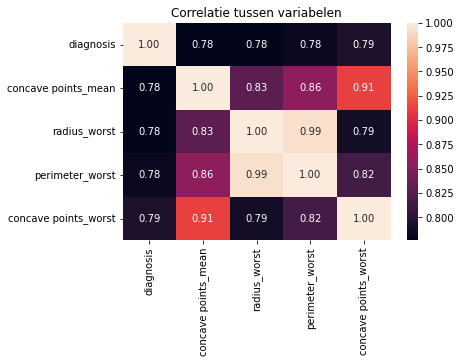

In [35]:
#weer de variabalen weergeven in een plot
sns.heatmap(df2[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlatie tussen variabelen")
plt.show()

In [36]:
#de sterk correlerende variabelen verder voorspellen 
y = df2.diagnosis
X = df2.drop(["diagnosis"], axis = 1)
columns = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

clf_knn = KNeighborsClassifier(n_neighbors=2)
clf_knn.fit(X_train, y_train)
acc_knn = round(clf_knn.score(X_train, y_train)*100, 2) #afronden op 2 decimalen
print(acc_knn)

94.29


In [37]:
clf_svm = SVC() #model classificatie
clf_svm.fit(X_train, y_train) #het model fitten op training dataset

acc_svm = round(clf_svm.score(X_train, y_train)*100, 2) #afronden op 2 decimalen
print(acc_svm)

91.43


In [38]:
clf_logreg = LogisticRegression(random_state=0) #model classificatie
clf_logreg = LogisticRegression(solver='liblinear')
clf_logreg.fit(X_train, y_train) #het model fitten op training dataset

Y_pred = clf_logreg.predict(X_test)

acc_logistic = round(clf_logreg.score(X_train, y_train)*100, 2) #afronden op 2 decimalen
print(acc_logistic)

95.82


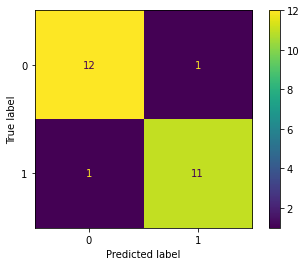

In [39]:
#werkelijke en voorspelde gegevens tegen elkaar opzetten in een confusion matrix, 1 is voor kwaadaardig en 0 voor goedaardig
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = LogisticRegression(random_state=0) 
clf.fit(X_train, y_train)
SVC(random_state=0)
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

## Vanaf hier begint opdracht 2 die doorgaat op opdracht 1

#### Waarom hebben we deze prestatiemetrics gekozen? 
De confusion matrix laat duidelijk zien of je model nauwkeurig is of niet aan de hand
van de False Positive en de True Negative, hier is te zien dat daarin maar 2 fouten zijn, dus het model verder een hoge nauwkeurigheid heeft.

#### Welke waarde van k hebben we gekozen bij cross validation?
We hebben gekozen voor de waarde k=3, ofwel cv=3, waarbij we een hoge nauwkeurigheid krijgen

#### Wat doet de verandering van de hyperparameters met de waarde van het model?
We hebben de hyperparameters getest met een functie die de beste parameters kiest voor het model. We hebben het met verschillende waardes uitgeprobeerd
die uit de RandomizedSearchCV komen en daarin is het getal wat eruit komt de ene keer hoger dan de andere keer. Daar is geen logisch verband uit te halen.

#### Hoe goed is het model?
We komen uit op een waarde van 96.04, dat is een erg hoge score dus ook een hoge nauwkeurigheid, waarbij het niet te hoog is voor een overfit.


## Hieronder gaat nu opdracht 2 verder

In [40]:
#Hier scheiden we de X in underfit en overfit (die komt later in de code) met de lage en hoge waardes die we meegeven om te testen
#wat voor een getal eruit komt

X_underfit = X[:50]
y_underfit = y[:50]

#Hier testen we de underfit variabelen
clf_logreg2 = LogisticRegression(random_state=0) #model classificatie
clf_logreg2 = LogisticRegression(solver='liblinear')
clf_logreg2.fit(X_underfit, y_underfit) #het model fitten op training dataset

Y_pred2 = clf_logreg2.predict(X_underfit)

acc_logistic2 = round(clf_logreg2.score(X_underfit, y_underfit)*100, 2) #afronden op 2 decimalen
print(acc_logistic2)

100.0


In [41]:
#Hier doen we hetzelfde maar dan dus met overfit
X_overfit = X[:400]
y_overfit = y[:400]

#Hier testen we de overfit
clf_logreg3 = LogisticRegression(random_state=0) #model classificatie
clf_logreg3 = LogisticRegression(solver='liblinear')
clf_logreg3.fit(X_overfit, y_overfit) #het model fitten op training dataset

Y_pred3 = clf_logreg3.predict(X_overfit)

acc_logistic3 = round(clf_logreg3.score(X_overfit, y_overfit)*100, 2) #afronden op 2 decimalen
print(acc_logistic3)

93.0


Onze overfit en underfit resultaten zijn niet duidelijk hoge en lage waardes, maar eigenlijk allebei hoog. Hierin is dus niet duidelijk het verschil gezien bij welke waardes het model overfit of underfit

In [42]:
from sklearn.model_selection import RandomizedSearchCV

#de sterk correlerende variabelen verder voorspellen 
logModel = LogisticRegression()

In [43]:
#de hyperparameters meegeven
param_grid = [
    {'penalty' : ['l', 'l2', 'elasticnet', 'none'],
     'C' : np.logspace(-4, 4, 20),
     'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
     'max_iter' : [100, 1000, 2500, 5000]
    }
]

We hebben een screenshot hieronder toegevoegd van de overige code. De code runt namelijk wel in de server, maar op de een of andere manier niet lokaal op jupyter notebook.

<img src='ss_dm.png' style='width:1700px;height:500px'/>